In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!kaggle datasets download -d danielwillgeorge/glove6b100dtxt -p data/ --unzip

]4;0;rgb:0c/0d/0e\]4;1;rgb:e3/1a/1c\]4;2;rgb:31/a3/54\]4;3;rgb:dc/a0/60\]4;4;rgb:31/82/bd\]4;5;rgb:75/6b/b1\]4;6;rgb:80/b1/d3\]4;7;rgb:b7/b8/b9\]4;8;rgb:73/74/75\]4;9;rgb:e3/1a/1c\]4;10;rgb:31/a3/54\]4;11;rgb:dc/a0/60\]4;12;rgb:31/82/bd\]4;13;rgb:75/6b/b1\]4;14;rgb:80/b1/d3\]4;15;rgb:fc/fd/fe\]4;16;rgb:e6/55/0d\]4;17;rgb:b1/59/28\]4;18;rgb:2e/2f/30\]4;19;rgb:51/52/53\]4;20;rgb:95/96/97\]4;21;rgb:da/db/dc\]Pgb7b8b9\]Ph0c0d0e\]Pib7b8b9\]Pj515253\]Pkb7b8b9\]Plb7b8b9\]Pm0c0d0e\Warning: Your Kaggle API key is readable by other users on this system! To fix this, you can run 'chmod 600 /Users/ab2177/.kaggle/kaggle.json'
 97%|██████████████████████████████████████▉ | 128M/131M [00:03<00:00, 40.5MB/s]
100%|████████████████████████████████████████| 131M/131M [00:03<00:00, 40.6MB/s]


In [ ]:
%env KAGGLE_USERNAME=
%env KAGGLE_KEY=

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

plt.style.use("fivethirtyeight")


In [4]:
RANDOM_STATE = 50
EPOCHS = 150
BATCH_SIZE = 2048
TRAINING_LENGTH = 50
TRAIN_FRACTION = 0.7
LSTM_CELLS = 64
VERBOSE = 1
SAVE_MODEL = True

In [5]:
data = pd.read_csv("data/machine-learning.csv", parse_dates=['patent_date'])
data = data.dropna()
len(data)


6558

Text(0.5, 1.0, 'Machine learning patents over time')

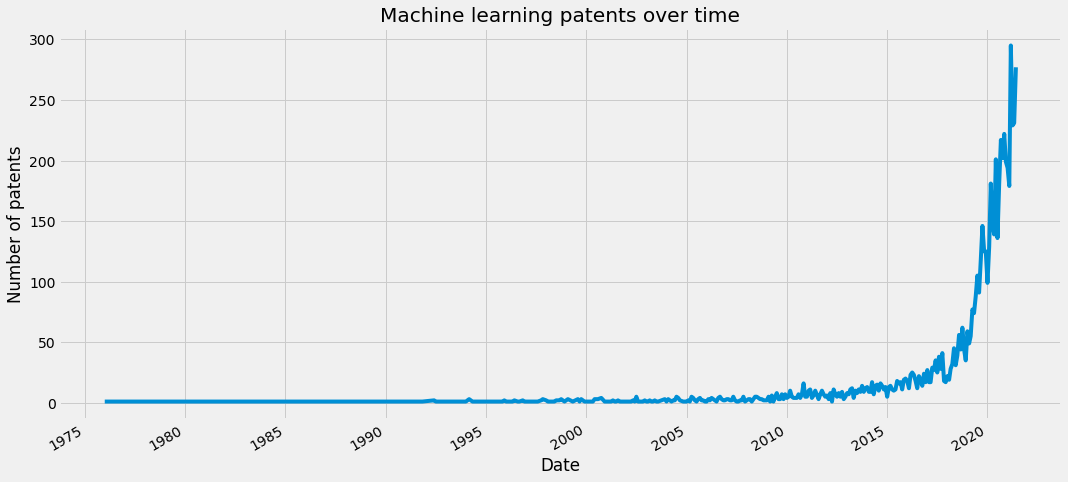

In [6]:
from datetime import datetime

data["year-month"] = [
    datetime(year, month, 1)
    for year, month in zip(
        data["patent_date"].dt.year,
        data["patent_date"].dt.month,
    )
]
monthly = data.groupby("year-month")["patent_number"].count()
monthly.plot(figsize=(16, 8))
plt.ylabel("Number of patents")
plt.xlabel("Date")
plt.title("Machine learning patents over time")


Text(0.5, 1.0, 'Neural Network patents by year')

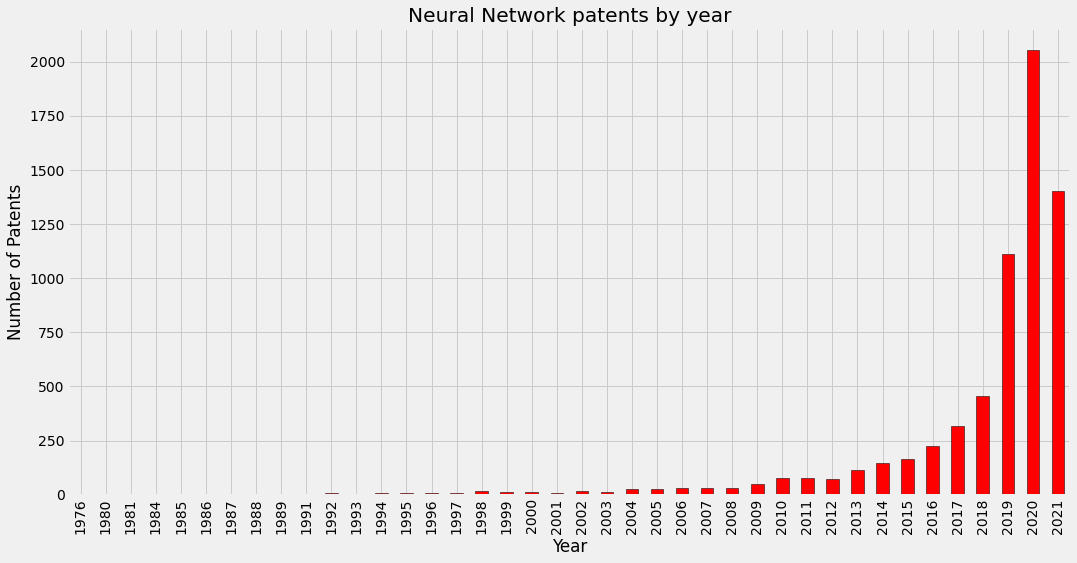

In [7]:
data["year"] = [year for year in data["patent_date"].dt.year]
yearly = data.groupby("year")["patent_number"].count()
yearly.plot.bar(
    color="red",
    edgecolor="k",
    figsize=(16, 8),
)
plt.xlabel("Year")
plt.ylabel("Number of Patents")
plt.title("Neural Network patents by year")


In [8]:
import re


def format_patent(patent):
    """Add spaces around punctuation and remove references to images/citations."""

    # Add spaces around punctuation
    patent = re.sub(r"(?<=[^\s0-9])(?=[.,;?])", r" ", patent)

    # Remove references to figures
    patent = re.sub(r"\((\d+)\)", r"", patent)

    # Remove double spaces
    patent = re.sub(r"\s\s", " ", patent)
    return patent


def remove_spaces(patent):
    """Remove spaces around punctuation"""
    patent = re.sub(r"\s+([.,;?])", r"\1", patent)

    return patent


In [9]:
original_abstracts = data["patent_abstract"].to_list()
formatted_abstracts = []

for abstract in original_abstracts:
    abstract = format_patent(abstract)
    formatted_abstracts.append(abstract)

In [10]:
from tensorflow.keras.preprocessing.text import Tokenizer


def make_sequences(
    texts,
    training_length=50,
    lower=True,
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
):
    """Turn a set of texts into sequences of integers"""

    # Create the tokenizer object and train on texts
    tokenizer = Tokenizer(lower=lower, filters=filters)
    tokenizer.fit_on_texts(texts)

    # Create look-up dictionaries and reverse look-ups
    word_idx = tokenizer.word_index
    idx_word = tokenizer.index_word
    num_words = len(word_idx) + 1
    word_counts = tokenizer.word_counts

    print(f"There are {num_words} unique words.")

    # Convert text to sequences of integers
    sequences = tokenizer.texts_to_sequences(texts)

    # Limit to sequences with more than training length tokens
    seq_lengths = [len(x) for x in sequences]
    over_idx = [
        i for i, l in enumerate(seq_lengths) if l > (training_length + 20)
    ]

    new_texts = []
    new_sequences = []

    # Only keep sequences with more than training length tokens
    for i in over_idx:
        new_texts.append(texts[i])
        new_sequences.append(sequences[i])

    training_seq = []
    labels = []

    # Iterate through the sequences of tokens
    for seq in new_sequences:

        # Create multiple training examples from each sequence
        for i in range(training_length, len(seq)):
            # Extract the features and label
            extract = seq[i - training_length : i + 1]

            # Set the features and label
            training_seq.append(extract[:-1])
            labels.append(extract[-1])

    print(f"There are {len(training_seq)} training sequences.")

    # Return everything needed for setting up the model
    return (
        word_idx,
        idx_word,
        num_words,
        word_counts,
        new_texts,
        new_sequences,
        training_seq,
        labels,
    )


In [11]:
filters = '!"#$%&()*+/:<=>@[\\]^_`{|}~\t\n'

(
    word_idx,
    idx_word,
    num_words,
    word_counts,
    abstracts,
    sequences,
    features,
    labels,
) = make_sequences(
    formatted_abstracts,
    TRAINING_LENGTH,
    lower=True,
    filters=filters,
)


There are 14999 unique words.
There are 529574 training sequences.


In [12]:
from sklearn.utils import shuffle


def create_train_valid(
    features, labels, num_words, train_fraction=TRAIN_FRACTION
):
    """Create training and validation features and labels."""

    # Randomly shuffle features and labels
    features, labels = shuffle(features, labels, random_state=RANDOM_STATE)

    # Decide on number of samples for training
    train_end = int(train_fraction * len(labels))

    train_features = np.array(features[:train_end])
    valid_features = np.array(features[train_end:])

    train_labels = labels[:train_end]
    valid_labels = labels[train_end:]

    # Convert to arrays
    X_train, X_valid = np.array(train_features), np.array(valid_features)

    # Using int8 for memory savings
    y_train = np.zeros((len(train_labels), num_words), dtype=np.int8)
    y_valid = np.zeros((len(valid_labels), num_words), dtype=np.int8)

    # One hot encoding of labels
    for example_index, word_index in enumerate(train_labels):
        y_train[example_index, word_index] = 1

    for example_index, word_index in enumerate(valid_labels):
        y_valid[example_index, word_index] = 1

    # Memory management
    import gc

    gc.enable()
    del (
        features,
        labels,
        train_features,
        valid_features,
        train_labels,
        valid_labels,
    )
    gc.collect()

    return X_train, X_valid, y_train, y_valid


In [13]:
X_train, X_valid, y_train, y_valid = create_train_valid(
    features,
    labels,
    num_words,
)


In [14]:
X_train.shape, y_train.shape

((370701, 50), (370701, 14999))

In [15]:
import sys

def check_sizes(gb_min=1):
    for x in globals():
        size = sys.getsizeof(eval(x)) / 1e9
        if size > gb_min:
            print(f'Object: {x:10}\tSize: {size} GB.')


check_sizes(gb_min=1)

Object: y_train   	Size: 5.560144419 GB.
Object: y_valid   	Size: 2.382936247 GB.


In [16]:
glove = np.loadtxt("data/glove.6B.100d.txt", dtype='str', comments=None)
glove.shape

(400000, 101)

In [17]:
vectors = glove[:, 1:].astype('float')
words = glove[:, 0]

In [18]:
word_lookup = {word: vector for word, vector in zip(words, vectors)}

embedding_matrix = np.zeros((num_words, vectors.shape[1]))

not_found = 0

for idx, word in idx_word.items():
    # Look up the word embedding
    vector = word_lookup.get(word)

    # Record in matrix
    if vector is not None:
        embedding_matrix[idx, :] = vector
    else:
        not_found += 1

print(f'There were {not_found} words without pre-trained embeddings.')

There were 3196 words without pre-trained embeddings.


In [19]:
embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))
embedding_matrix = np.nan_to_num(embedding_matrix)

/var/folders/0v/kyjb3cqj1pz5t9zqznwj_8100000gn/T/ipykernel_73264/270218822.py:1: RuntimeWarning: invalid value encountered in true_divide
  embedding_matrix = embedding_matrix / np.linalg.norm(embedding_matrix, axis=1).reshape((-1, 1))


In [20]:
def find_closest(query, embedding_matrix, word_idx, idx_word, n=10):
    """Find closest words to a query word in embeddings"""

    idx = word_idx.get(query, None)
    # Handle case where query is not in vocab
    if idx is None:
        print(f"{query} not found in vocab.")
        return
    else:
        vec = embedding_matrix[idx]
        # Handle case where word doesn't have an embedding
        if np.all(vec == 0):
            print(f"{query} has no pre-trained embedding.")
            return
        else:
            # Calculate distance between vector and all others
            dists = np.dot(embedding_matrix, vec)

            # Sort indexes in reverse order
            idxs = np.argsort(dists)[::-1][:n]
            sorted_dists = dists[idxs]
            closest = [idx_word[i] for i in idxs]

    print(f"Query: {query}\n")
    # Print out the word and cosine distances
    for word, dist in zip(closest, sorted_dists):
        print(f"Word: {word:15} Cosine Similarity: {round(dist, 4)}")


In [21]:
find_closest('the', embedding_matrix, word_idx, idx_word)

Query: the

Word: the             Cosine Similarity: 1.0
Word: this            Cosine Similarity: 0.8573
Word: part            Cosine Similarity: 0.8508
Word: one             Cosine Similarity: 0.8503
Word: of              Cosine Similarity: 0.8329
Word: same            Cosine Similarity: 0.8325
Word: first           Cosine Similarity: 0.821
Word: on              Cosine Similarity: 0.82
Word: its             Cosine Similarity: 0.8169
Word: as              Cosine Similarity: 0.8128


In [22]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Embedding,
    Masking,
    Bidirectional,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.initializers import Constant

from tensorflow.keras.utils import plot_model


In [23]:
def make_word_level_model(
    num_words,
    embedding_matrix,
    lstm_cells=64,
    trainable=False,
    lstm_layers=1,
    bi_direc=False,
):
    """Make a word level recurrent neural network with option for pretrained embeddings
    and varying numbers of LSTM cell layers."""

    model = Sequential()

    # Map words to an embedding
    if not trainable:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                embeddings_initializer=Constant(embedding_matrix),
                trainable=False,
                mask_zero=True,
            )
        )
        model.add(Masking())
    else:
        model.add(
            Embedding(
                input_dim=num_words,
                output_dim=embedding_matrix.shape[1],
                embeddings_initializer=Constant(embedding_matrix),
                trainable=True,
            )
        )

    # If want to add multiple LSTM layers
    if lstm_layers > 1:
        for _ in range(lstm_layers - 1):
            model.add(
                LSTM(
                    lstm_cells,
                    return_sequences=True,
                    dropout=0.1,
                    recurrent_dropout=0.1,
                )
            )

    # Add final LSTM cell layer
    if bi_direc:
        model.add(
            Bidirectional(
                LSTM(
                    lstm_cells,
                    return_sequences=False,
                    dropout=0.1,
                    recurrent_dropout=0.1,
                )
            )
        )
    else:
        model.add(
            LSTM(
                lstm_cells,
                return_sequences=False,
                dropout=0.1,
                recurrent_dropout=0.1,
            )
        )
    model.add(Dense(128, activation="relu"))
    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(num_words, activation="softmax"))

    # Compile the model
    model.compile(
        optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model


model = make_word_level_model(
    num_words,
    embedding_matrix=embedding_matrix,
    lstm_cells=LSTM_CELLS,
    trainable=False,
    lstm_layers=1,
)
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1499900   
                                                                 
 masking (Masking)           (None, None, 100)         0         
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 14999)             1934871   
                                                                 
Total params: 3,485,331
Trainable params: 1,985,431
Non-

2021-12-08 16:28:57.014258: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


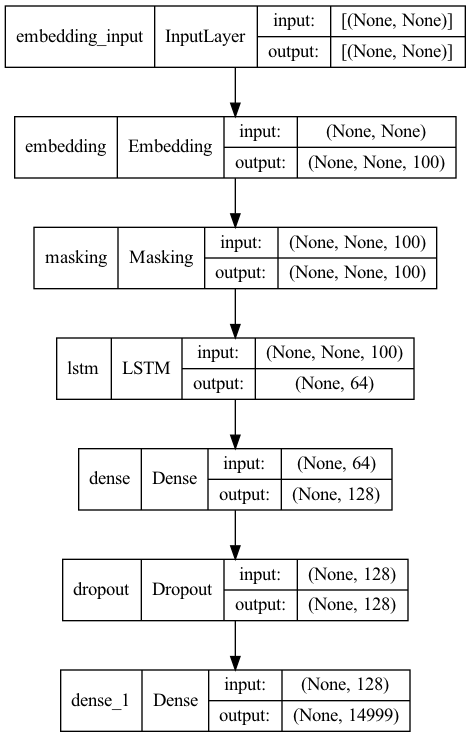

In [24]:
plot_model(model, show_shapes=True)

In [25]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

BATCH_SIZE = 2048

model_name = 'pre-trained-rnn'
model_dir = 'models'


def make_callbacks(model_name, save=SAVE_MODEL):
    """Make list of callbacks for training"""
    callbacks = [EarlyStopping(monitor='val_loss', patience=5)]

    if save:
        callbacks.append(
            ModelCheckpoint(
                f'{model_dir}/{model_name}.h5',
                save_best_only=True,
                save_weights_only=False))
    return callbacks


callbacks = make_callbacks(model_name)

In [26]:
history = model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=VERBOSE,
    callbacks=callbacks,
    validation_data=(X_valid, y_valid))

Epoch 1/150
182/182 [==============================] - 232s 1s/step - loss: 6.5900 - accuracy: 0.0758 - val_loss: 6.1370 - val_accuracy: 0.0866
Epoch 2/150
182/182 [==============================] - 222s 1s/step - loss: 6.1474 - accuracy: 0.0866 - val_loss: 6.0998 - val_accuracy: 0.0866
Epoch 3/150
125/182 [===================>..........] - ETA: 59s - loss: 6.0785 - accuracy: 0.0924 